# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      
---
* [ Transfer Learning2 ](#Transfer-Learning2 )
* [Incremental Learning](#Incremental-Learning)
    * [Catastrophic Forgetting](#Catastrophic-Forgetting/inferenc)
    * [Knowledge Distillation](#Knowledge-Distillation)

       
##   Transfer Learning2
 - 공개된 모델로 transfer learning해서 새로운 class 예측하게하는 기법
 
  > "사전 훈련된 모델은 이전에 대규모 데이터셋에서 훈련된 저장된 네트워크로, 일반적으로 대규모 이미지 분류 작업에서 훈련된 것입니다. 사전 훈련된 모델을 그대로 사용하거나 전이 학습을 사용하여 이 모델을 주어진 작업으로 사용자 정의하세요."

- 모델이 복잡할 수록 성능이 좋아지나 학습 문제점 생김
  1.  underfitting 문제
    - Batch Normalizatoin(BN) 으로 해결
  2. overfitting 문제
      - 인간을 뛰어넘었기 때문에 **효율성**에 초점(parameter 축소):eg. mobilenet,shufflenet
- 기족 학습 데이터 맞추고 학습된 모델의 유사성, 데이터 확인 필요 

  Imagenet 기반은 1000개의 클래스를 분류할수 있는 능력을 학습했기 때문에 fine tunning으로 새로운 클래스를 분류 가능
  - fine tunning : 새로운 레이어를 구성해서 학습
    - trainable technique으로 예측하는 부분만 재학습시킴
  - pre-trained model: 그대로 가져오는 경우 
    - 데이터가 많으면 구조를 가져와서 처음부터 다시 학습하면 제일 좋음
  - learning curve 확인 (적정 데이터양은 이미지와 모델의 복잡도에 따라 달라지기 때문)
  - data augmentation : overfitting 막으나 accuracy 급격하게 늘어나지않음

> 논문: How transferable are features in deep neural networks by Yoshua Bengio
    - 전이학습이 어떻게 활용 되는지 이론적 내용 정리
    - 책: Hands-On Transfer Learning with Python Implement advanced deep learning and neural network models using TensorFlow and Keras(tf 이전 버전)

> 데이터가 별로 없는 경우 학습 시키는 기법 few-shot learning 

In [2]:
import tensorflow_datasets as tfds  #tf연습용 데이
import tensorflow as tf

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
                                                            'cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete88YNQI/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


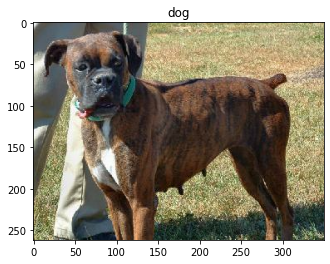

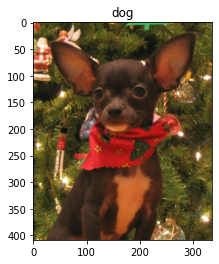

In [4]:
#EDA 이미지 크기 상이
import matplotlib.pyplot as plt
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()    #이미지 여러개 한번에 나오게 함
  plt.imshow(image)
  plt.title(get_label_name(label))

In [6]:
#모델 내에서 데이터가 들어오면 layer에서 resize (Flatten과 비슷)
tf.keras.layers.experimental.preprocessing.Resizing 

tensorflow.python.keras.layers.preprocessing.image_preprocessing.Resizing

In [7]:
#데이터 자체를 변화시킴 :tf.image :tf.data.Dataset 만들면  tensor로 데이터 관리, 기능 상속해서 prefetch 등으로 최적 학습 요건 만듦 
tf.image.resize

<function tensorflow.python.ops.image_ops_impl.resize_images_v2>

전체 데이터 변환 적용
- for :비효율적
- map :함수형 패러다임

In [5]:
#이미지 크기 맞춤 : resize, crop
IMG_SIZE = 160 # 모든 이미지는 160x160으로 크기가 조정

def format_example(image, label):
  image = tf.cast(image, tf.float32) #타입 변경
  image = (image/127.5) - 1          #zero-centered [-1,1 ] (AlexNEt,2012)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) #160,160크기로 맞춤
  return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
train  #Dataset 

In [10]:
tf.data.Dataset.from_tensors([1,2,3])

<TensorDataset shapes: (3,), types: tf.int32>

In [9]:
tf.data.Dataset.from_tensor_slices([[1,2],[3,4]])  #이 형태로 변경 fitting에 더 편리

<TensorSliceDataset shapes: (2,), types: tf.int32>

In [11]:
#tensor로 데이터 관리 
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000 
# tf.data prefetch(AUTOTUNE)도 가능

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [12]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape   #데이터 검사 160x 160 색 이미지 32

TensorShape([32, 160, 160, 3])

In [13]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성
#include_top FCNN 가져올지 여부,weights= imagenet에서 학습된 가중치
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
base_model.trainable=False #Trainable parameters =0

depth wise 효율성 위해서 사용
- 학습 파라미터 줄여주는 기법


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

imagenet 학습한 모델은 많은 데이터로 학습했기 때문에 어느정도 성능 보장하기 때문에 classifier 부분 교체
 - NFL : 데이터가 작은 경우 GAP, 많으면 FCNN
 - CNN에서 feature extraction 성능 좋으면 마지막은 FCNN 2개 정도 사용
    - Global Average Pooling
    - Fully connected neural network

In [27]:
#multi-inputs, multi outputs 모델도 sequential 내부에 들어가 하나처럼 사용 가능
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1),
])
model.summary()  #Dense: trainable parameter 많음 

#from_logits=True 하면 활성화 함수 사용하지 않아도 numerical stability 제공하여 성능 안정적
model.compile(optimizer='adam',  metrics=['accuracy'],
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 32001     
Total params: 2,289,985
Trainable params: 32,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
initial_epochs = 10
validation_steps=20
#acuracy 49%
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps) 

20/20 [==============================] - 1s 53ms/step - loss: 0.9268 - accuracy: 0.4953


In [19]:
#데이터 3,000개임에도 성능이 좋음 ; val acc 98.19%
#NFL :상황에 따라서 accuracy vs  traniable parameters
history = model.fit(train_batches,
                    epochs=initial_epochs,
                   validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 46s 79ms/step - loss: 0.1955 - accuracy: 0.9718 - val_loss: 0.1479 - val_accuracy: 0.9824
Epoch 2/10
582/582 [==============================] - 45s 77ms/step - loss: 0.0665 - accuracy: 0.9888 - val_loss: 0.2011 - val_accuracy: 0.9798
Epoch 3/10
582/582 [==============================] - 46s 78ms/step - loss: 0.0354 - accuracy: 0.9935 - val_loss: 0.1919 - val_accuracy: 0.9824
Epoch 4/10
582/582 [==============================] - 46s 80ms/step - loss: 0.0397 - accuracy: 0.9941 - val_loss: 0.2492 - val_accuracy: 0.9789
Epoch 5/10
582/582 [==============================] - 46s 79ms/step - loss: 0.0167 - accuracy: 0.9965 - val_loss: 0.2434 - val_accuracy: 0.9807
Epoch 6/10
582/582 [==============================] - 46s 79ms/step - loss: 0.0201 - accuracy: 0.9967 - val_loss: 0.2461 - val_accuracy: 0.9789
Epoch 7/10
582/582 [==============================] - 46s 79ms/step - loss: 0.0340 - accuracy: 0.9949 - val_loss: 0.3009 - val_accuracy:

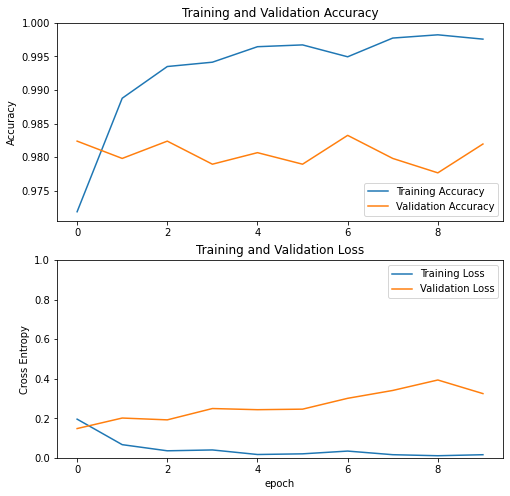

In [20]:
#정확한 비교를 위해서 그래프
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


#해석1: accuracy 크게 요동치지 않음(0.001 차이) 파라미터가 많아서 데이터가 더 많이 필요함 test 데이터가 적기 때문
#해석2: loss도 FCNN이 train, validation 차이가 큼
# Global Average Pooling  1,281 > FCNN 32,001 

간단하게 해도 성능이 좋음

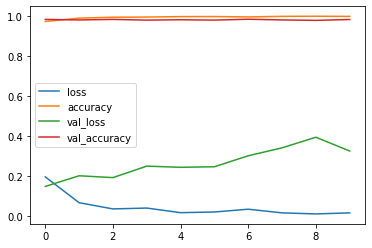

In [29]:
import pandas as pd
pd.DataFrame(history.history).plot.line() #전체적인 비교 한눈에 함

In [26]:
#Global Average Pooling 비교 
model1 = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1)
])
model1.summary()  #Dense: trainable parameter 많음 

model1.compile(optimizer='adam',  metrics=['accuracy'],
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

history1 = model1.fit(train_batches,
                    epochs=initial_epochs,
                   validation_data=validation_batches)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
582/582 [==============================] - 46s 79ms/step - loss: 0.0834 - accuracy: 0.9656 - val_loss: 0.0490 - val_accuracy: 0.9807
Epoch 2/10
582/582 [==============================] - 46s 78ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.0446 - val_accuracy: 0.9837
Epoch 3/10
582/582 [==============================] - 46s 79ms/step - loss: 0.0397

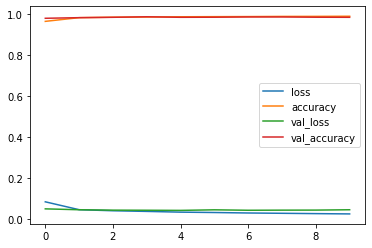

In [30]:
# Global Average Pooling:정확도, loss모두 차이 거의 없고 안정적
pd.DataFrame(history1.history).plot.line() #GAP 안정적

[전이학습](https://www.tensorflow.org/guide/keras/transfer_learning)
- 데이터가 적어 모델 전체를 처음부터 학습 시킬수 없을때 모델 그대로 가져와서 구조만 가져와서 학습, fine-tunning 뒷부분만 수정하는것 
- 너구리(racoons) 식별하는 방법을 배운 모델의 특징은  일본 너구리(tanukis)식별하도록 적이 학습 가능
### work flow
1. 기본 모델을 인스턴스화하고 사전 훈련 된 가중치를 여기에 로드합니다.
    - data 크기, 모델 유사도기반으로 결정
2. `trainable = False` 를 설정하여 기본 모델의 모든 레이어를 고정합니다.(True 기본값)
    - 학습 시키지 않을 레이어 지정
3. 고정 된 레이어 위에 새로운 학습 가능한 레이어를 추가합니다. 새 데이터 세트에서 이전 기능을 예측으로 바꾸는 방법을 배웁니다.

4. 데이터 세트에서 새 레이어를 학습시킵니다.
5. (선택) 미세조정: 위에서 얻은 전체 모델의 일부를 고정해제, 학습률이 낮은 새 데이터에 대해 다시 학습
    - 사전 학습 된 기능을 새 데이터에 점진적으로 적용하여 개선
    
### trainable API
- model, layers 가중치 속성
- weights : 레이어의 모든 가중치 변수 목록
    - trainable_weights: 훈련시 경사하강법을 통해 업데이트 될 목록
        - 기본적으로 trainable =True로 되어있음
            - trainable값 변경한 경우 compile 다시 호출해야함
    - non_trainable_weights: 훈련시 업데이트 되지 않음
 - `Dense` : kernel, bias
 
      > keras build
      - functional paradigm `\_\_call__` -> 내부적으로 build 1번만 부름-> call()
      build( None,input_shape 4)

In [ ]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

#### BatchNormalization
- 더 깊은 모델이 학습 가능해짐 scale($\alpha$)&shift($\beta$) 학습.
- train,test 시에 다르게 사용
      - `keras.layers.BatchNormalization()` 2개의 학습 가중치,2개의 불가중치
        - 훈련 할 수없는 가중치를 사용하여 훈련 중 입력 값의 평균과 분산을 추적합니다.      

Xception keras에서 만든 경량 모델 -imagenet에서 학습( 224,224)ㅡ

In [ ]:
#학습시키면 잘 안되기 때문에 새로운 레이어 추가 
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  #  ImageNet classifier 제외해서 가져옴

- 레이어/모델의 trainable 속성
-  `trainable=False`: 해당 레이어의 가중치가 학습 가능에서 학습 불가능으로 만듦( freezing)
    - 훈련 중에 업데이트 되지 않음
    - 모든 하위 레이어도 학습 하지 않도록 적용 가능

In [ ]:
#Model : multi-inputs, outputs; Sequential도 가능
base_model.trainable=False   #업데이트 안 되도록 feezing!

inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

## 미세 조정

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)

---
## Incremental Learning
-  이미 학습된 지식이 있는 모델 기반으로 비슷한 능력을 갖을수 있도록 해주는것이 공통점 떄문에 전이학습과 개념이 비슷하여 혼동

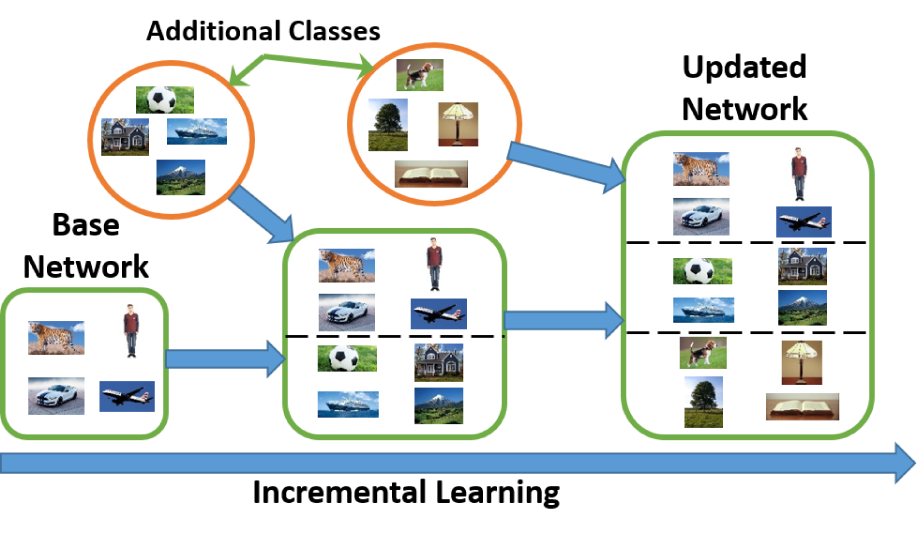
- n개 분류하는 모델에 새로운 클래스를 추가 학습하여 더 많은 클래스를 분류하도록 모델에 추가함
  > transferlearning : 학습된 모델을 가져와서 새로운 도메인에 적용

  keras는 학습한 상황을 기준으로 추가되어 학습됨( scikit과 다름)

In [41]:
# 학습된 상황 check :keras문법을 사용하지만  tensorflow,tiano -> MS CNTK 내부로 처
tf.keras.backend.get_value(model.optimizer)

In [40]:
tf.keras.backend.get_value(model.optimizer.iterations) #5820번 iteration

5820

- batch learning (데이터가 어느정도 들어왔을때 학습) 아닌 online learning( 데이터가 계속들어오고 학습도 계속 학습- 비지도 학습)
    -  때문에 비지도 학습(자기 학습) -> 범용 인공지능
    - 과거 경험을 바탕으로 분류하는데 새로운 클래스가 들어와서 같이 학습하면 더 빠르게 학습
    - eg.ImageNEt 1000개 분류하는 모델이 있다면 다른 새로운 데이터 추가하며 1000 +N개 분류하는건 incremental learning, N개만 분류하면 Transfer learning

### Catastrophic Forgetting/inference
 - Incremental Learning 새로운거 학습하면서 기존에 학습한것에 대한 성능이 나빠져서 아예 처음부터 학습시키는 것이 incremental learning 더 성능이 좋은 경우가 많음

논문: An Empirical Investigation of Catastrophic Forgetting in Gradient-Basesd Neural Networks by Ian Goodfellow
- Abstract:  머신러닝 모델과 알고리즘에서 나오는 문제(NFL, 경험적), 특히 NN
    - **해결책: dropout**  
        - 학습시에 랜덤하게 가중치를 소거해서 소거된 여러개가 합쳐져서 하나의 모델처럼 행동하기 때문
    > transfer learning 에서도 마지막 레이어를 fine tuning 하는 이유
    - BN은 regulariazation 역할을 해서 과적합 방지하는데 같이 사용

### Knowledge Distillation
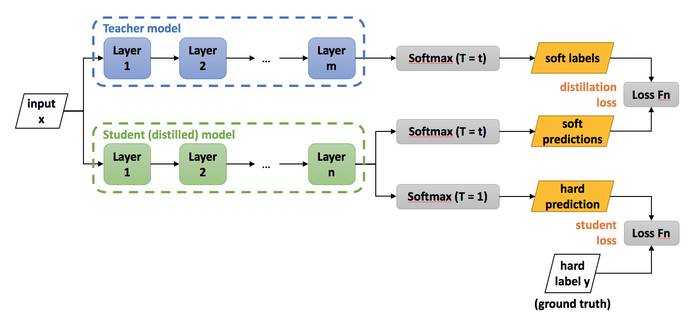
-  Incremental Learning 하위 기법(2016): 미리 학습된 큰 네트워크의 지식을 작은 네트워크에 전달하여 작은 네트워크에서도 비슷한 성능을 낼수있도록하는ㄴ것이 목적(경량화)
     > distillation(증류) : 불순물이 섞여 있는 혼합물에서 원한느 특정성분을 분리시키는 방법
- ensemble로 일반화된 성능을 높일수 있는데 복잡한 ensembled NN 의 결과 (softmax output) 으로 지식을 상대적으로 작은 규모의 NNd로 전달  
- 학습할 때 선생님을 모셔와서 불필요한 지식을 증류시키고 필요한 지식만 가져올 수 있도록 학생에게 도움을 줌으로써 간단한 모델에서도 좋은 성능 나옴
    - teacher model: 복잡한 ensemble 모델
    - student(distilled) model : 간단한 모델
    
losss function
1. classification loss : 학생 모델에서 학습을 통한 분류 결과와 ground truth 차이를 계산
    -  student model의 실제 정답을 예측하도록 하는 hard prediction하도록
 
2. distillation loss :선생님 모델과 학생모델의 분류결과의 차이를 loss로 포함
    - teacher model의 soft label을 student model의 soft prediction하도록
    - 학생모델이 선생님 모델의 분류결과를 모방하도록 학습시킴
    $L(x;W)=α∗H(y,σ(z_s;T=1))+(1-α)∗H(σ(z_t;T=τ),σ(z_s,T=τ))$
    - H:Cross entropy loss
    - σ:softmax
    - Z:output logits of Studnet/Teacher model
    - α:Balancing parameter
    - T:Temperature parameter
 
지식
-  hard coding: one hot encoding  [ 0 1 0 0 ]
-  soft coding: softmax (확률)     [1e-6 .9 .1 1e-9] 
    - 하단이 각 클래스에 얼마만큼 예측했었는지 더 많은 정보를 담음
    - 값들이 너무 작아서 모델에 반영하기 쉽지 않을수 있어서 softer softmax 분포를 부드럽게 만들어줌  [.05 .3 .2 5e-3]
    
softer softmax
- $p_i = \frac{exp(z_i/T)}{\sum(z_j/T)}$
- temperature parameter T
    - 온도가 높을수록 부드러운 prob distribution을 얻음 
    - NN에서 불피요하게 많은 파라미터가 사용되는 경우 ensemble model로부터 일반화 성능을 기존 대비 향상시킬수 있는 지식을 분리해냄
    >  온도가 2~4사이에서 제일 효과적 (richer information)
        - 1 : 무변
    > softmax output 을 받은것만으로도 학습하지 않은 데이터를 학생모델이 정답을 유추해냄 
  
- 레이어가 많고 복잡한 문제에서는 softmax output만으로는 부족

  > GAN(Generative Adversarial Network) : 사기꾼이 위조하면 경찰은 위조한것을 잘 감별함
  - 적대적 경쟁 :위조인지 아닌지 확인 왜 사기인지 알려줘서 기반 학습해서 위조를 잘하게 됨.
  - 경찰이 사기를  못찾는 정도가 되면 왜 사기인지 피드백 받아서 경쟁해서 성능을 높임 

참고 : Knowledge_Distillation_Notebook.ipynb

- [awsome knowledge distillation](https://github.com/dkozlov/awesome-knowledge-distillation)